### LSTM

In [1]:
#import
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### setup device

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Making data ready

In [23]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()

# data_norm.head(10)

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

Ploting the data....


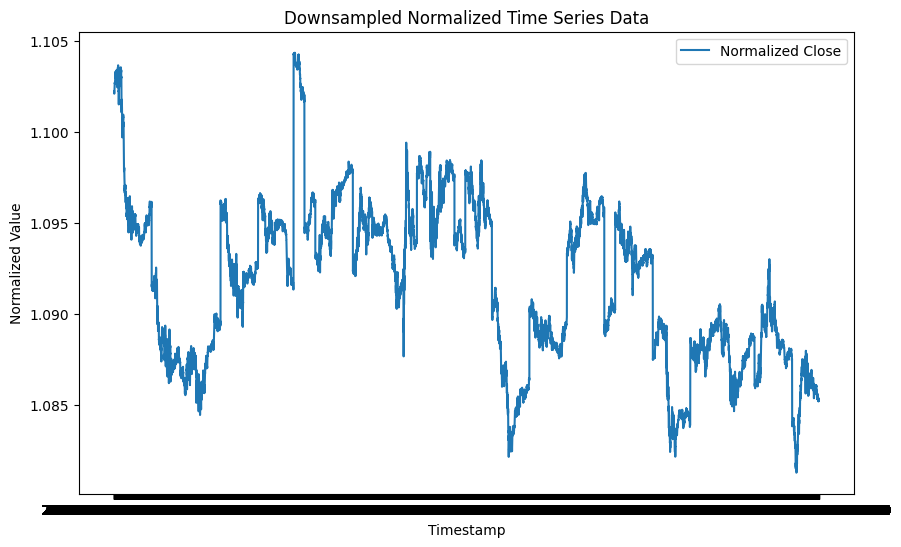

In [6]:

print("Ploting the data....")

# Downsample the data
# downsampled_data_norm = data_norm.resample('1D', on='timestamp').mean()

# Plot the downsampled data
plt.figure(figsize=(10, 6))
# plt.plot(data_norm['timestamp'], data_norm['open'], label='Normalized Open')
# plt.plot(data_norm['timestamp'], data_norm['high'], label='Normalized High')
# plt.plot(data_norm['timestamp'], data_norm['low'], label='Normalized Low')
plt.plot(data['timestamp'], data['close'], label='Normalized Close')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Downsampled Normalized Time Series Data')
plt.legend()
plt.show()

### move data to tensor gpu

In [24]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor

tensor([[[1.0697],
         [1.0697],
         [1.0697],
         ...,
         [1.1037],
         [1.1037],
         [1.1036]]], device='cuda:0')

In [13]:

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

# Parameters
input_size = 4  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.0094
Epoch [2/1000], Loss: 1.0073
Epoch [3/1000], Loss: 1.0055
Epoch [4/1000], Loss: 1.0040
Epoch [5/1000], Loss: 1.0027
Epoch [6/1000], Loss: 1.0017
Epoch [7/1000], Loss: 1.0009
Epoch [8/1000], Loss: 1.0004
Epoch [9/1000], Loss: 1.0001
Epoch [10/1000], Loss: 1.0001
Epoch [11/1000], Loss: 1.0003
Epoch [12/1000], Loss: 1.0005
Epoch [13/1000], Loss: 1.0008
Epoch [14/1000], Loss: 1.0009
Epoch [15/1000], Loss: 1.0008
Epoch [16/1000], Loss: 1.0007
Epoch [17/1000], Loss: 1.0005
Epoch [18/1000], Loss: 1.0003
Epoch [19/1000], Loss: 1.0002
Epoch [20/1000], Loss: 1.0001
Epoch [21/1000], Loss: 1.0000
Epoch [22/1000], Loss: 1.0000
Epoch [23/1000], Loss: 1.0000
Epoch [24/1000], Loss: 1.0001
Epoch [25/1000], Loss: 1.0001
Epoch [26/1000], Loss: 1.0001
Epoch [27/1000], Loss: 1.0001
Epoch [28/1000], Loss: 1.0001
Epoch [29/1000], Loss: 1.0001
Epoch [30/1000], Loss: 1.0001
Epoch [31/1000], Loss: 1.0001
Epoch [32/1000], Loss: 1.0001
Epoch [33/1000], Loss: 1.0001
Epoch [34/1000], Lo

KeyboardInterrupt: 

### LSTM in every 100 bars

In [25]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

### Train Modals

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 49/1000 [01:31<29:52,  1.88s/it]

Epoch [50/1000], Loss: 0.0049


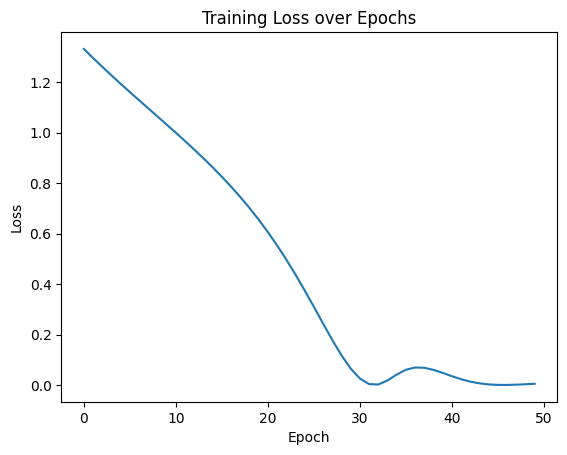

  5%|▌         | 50/1000 [01:33<30:31,  1.93s/it]

tensor([[[0.0542]]], device='cuda:0')
tensor([[0.1150]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322640, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|▉         | 99/1000 [03:10<29:32,  1.97s/it]

Epoch [100/1000], Loss: 0.0003


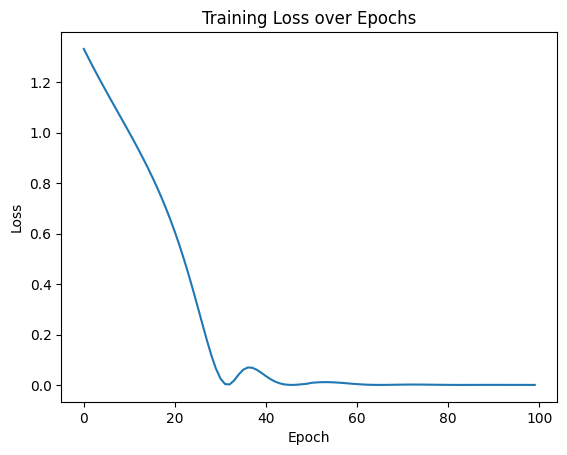

 10%|█         | 100/1000 [03:12<30:03,  2.00s/it]

tensor([[[0.1150]]], device='cuda:0')
tensor([[0.1248]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322641, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 15%|█▍        | 149/1000 [04:48<27:57,  1.97s/it]

Epoch [150/1000], Loss: 0.0003


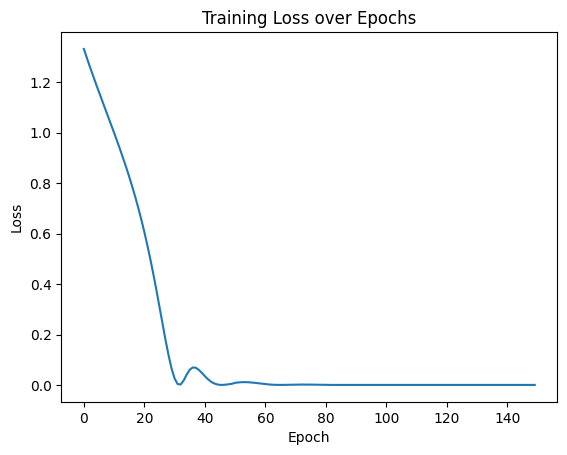

 15%|█▌        | 150/1000 [04:50<28:26,  2.01s/it]

tensor([[[0.1248]]], device='cuda:0')
tensor([[0.1254]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322642, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|█▉        | 199/1000 [06:26<25:05,  1.88s/it]

Epoch [200/1000], Loss: 0.0003


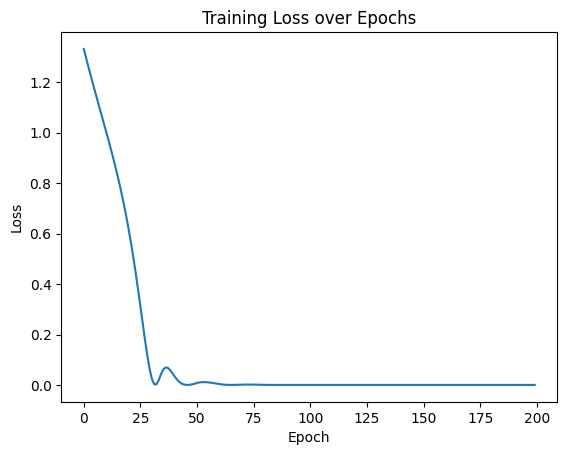

 20%|██        | 200/1000 [06:28<25:34,  1.92s/it]

tensor([[[0.1254]]], device='cuda:0')
tensor([[0.1258]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322643, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 25%|██▍       | 249/1000 [08:06<24:54,  1.99s/it]

Epoch [250/1000], Loss: 0.0003


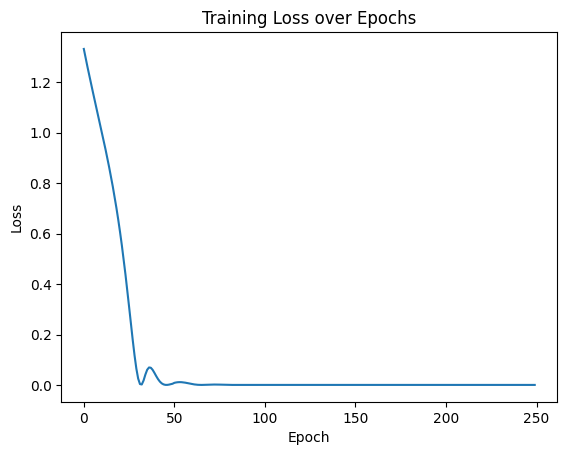

 25%|██▌       | 250/1000 [08:08<25:15,  2.02s/it]

tensor([[[0.1258]]], device='cuda:0')
tensor([[0.1262]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322644, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 30%|██▉       | 299/1000 [09:47<24:38,  2.11s/it]

Epoch [300/1000], Loss: 0.0003


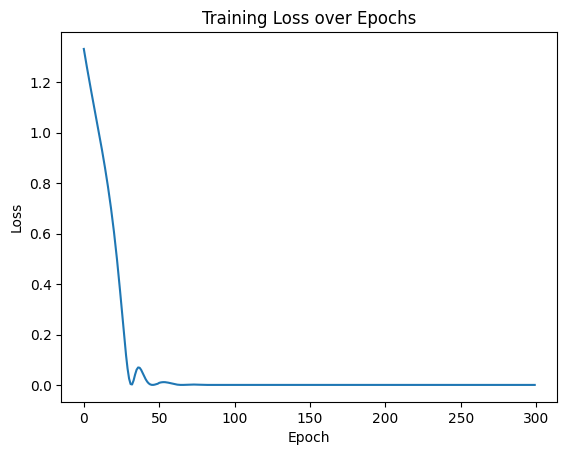

 30%|███       | 300/1000 [09:49<24:56,  2.14s/it]

tensor([[[0.1262]]], device='cuda:0')
tensor([[0.1265]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322645, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 35%|███▍      | 349/1000 [11:26<21:01,  1.94s/it]

Epoch [350/1000], Loss: 0.0003


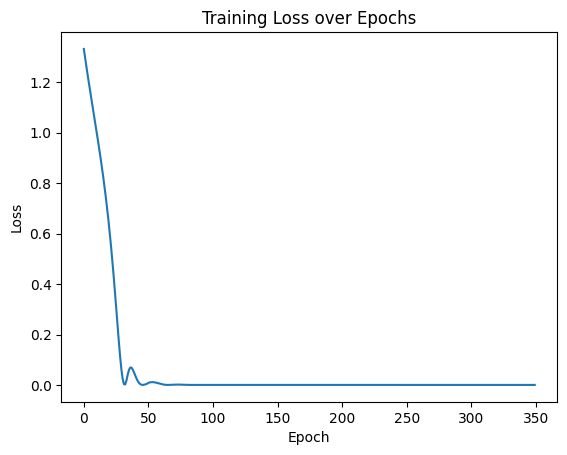

 35%|███▌      | 350/1000 [11:28<21:22,  1.97s/it]

tensor([[[0.1265]]], device='cuda:0')
tensor([[0.1268]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322646, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 40%|███▉      | 399/1000 [13:05<19:38,  1.96s/it]

Epoch [400/1000], Loss: 0.0003


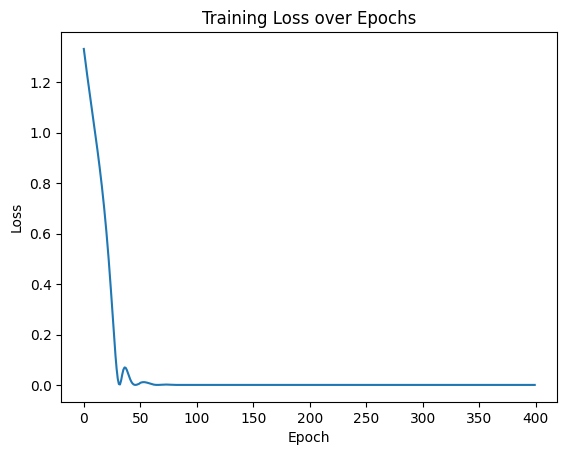

tensor([[[0.1268]]], device='cuda:0')


 40%|████      | 400/1000 [13:07<19:59,  2.00s/it]

tensor([[0.1270]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322647, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 45%|████▍     | 449/1000 [14:42<17:55,  1.95s/it]

Epoch [450/1000], Loss: 0.0003


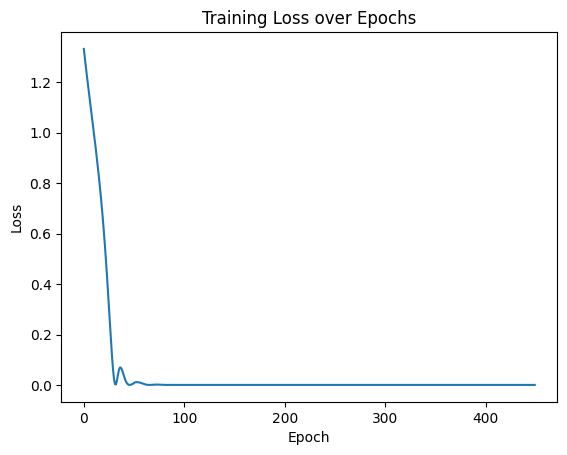

 45%|████▌     | 450/1000 [14:44<18:10,  1.98s/it]

tensor([[[0.1270]]], device='cuda:0')
tensor([[0.1272]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322648, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|████▉     | 499/1000 [16:32<18:29,  2.22s/it]

Epoch [500/1000], Loss: 0.0003


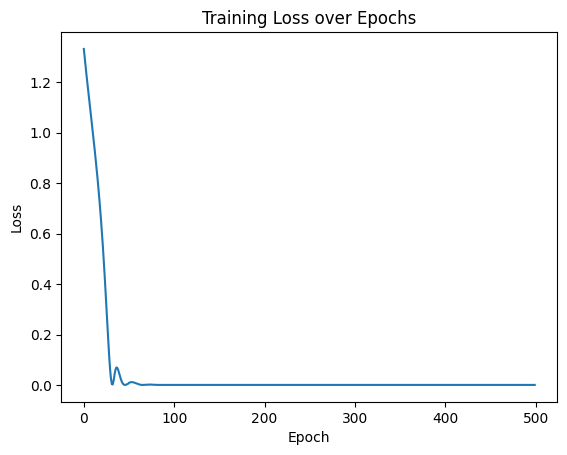

 50%|█████     | 500/1000 [16:34<17:58,  2.16s/it]

tensor([[[0.1272]]], device='cuda:0')
tensor([[0.1274]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322649, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 55%|█████▍    | 549/1000 [18:16<14:39,  1.95s/it]

Epoch [550/1000], Loss: 0.0003


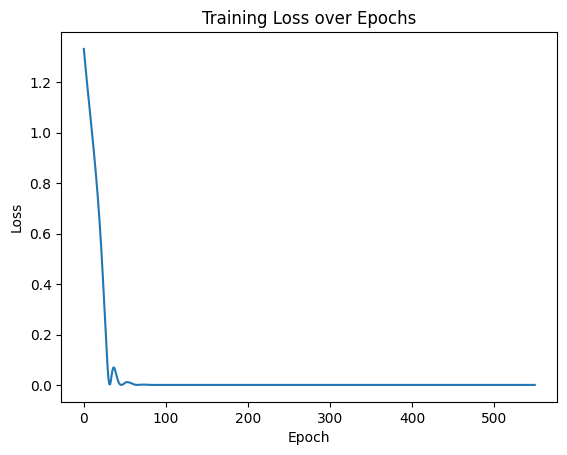

 55%|█████▌    | 550/1000 [18:18<14:42,  1.96s/it]

tensor([[[0.1274]]], device='cuda:0')
tensor([[0.1276]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322650, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 60%|█████▉    | 599/1000 [19:53<13:35,  2.03s/it]

Epoch [600/1000], Loss: 0.0003


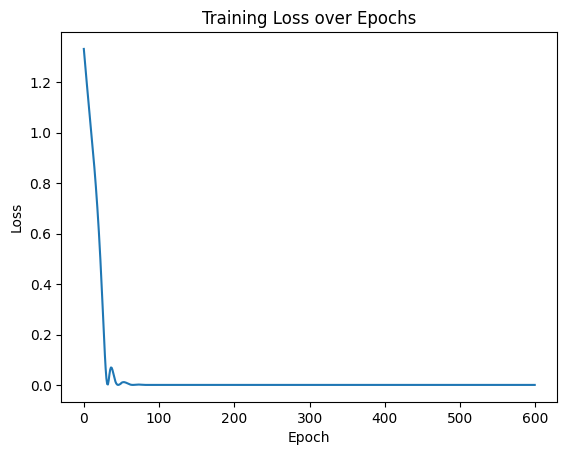

 60%|██████    | 600/1000 [19:55<13:52,  2.08s/it]

tensor([[[0.1276]]], device='cuda:0')
tensor([[0.1277]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322651, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 65%|██████▍   | 649/1000 [21:33<12:11,  2.08s/it]

Epoch [650/1000], Loss: 0.0003


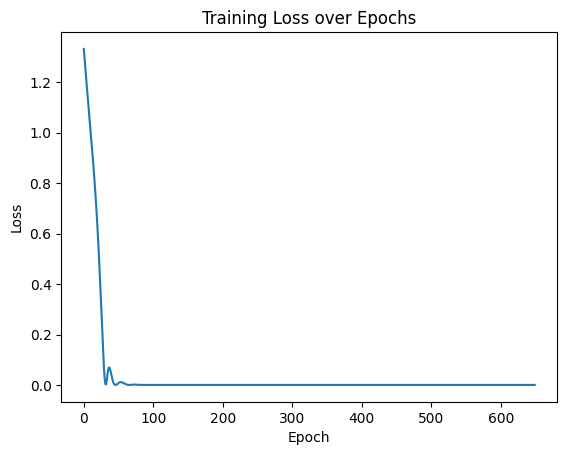

 65%|██████▌   | 650/1000 [21:36<12:20,  2.11s/it]

tensor([[[0.1277]]], device='cuda:0')
tensor([[0.1278]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322652, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 70%|██████▉   | 699/1000 [23:14<10:21,  2.06s/it]

Epoch [700/1000], Loss: 0.0003


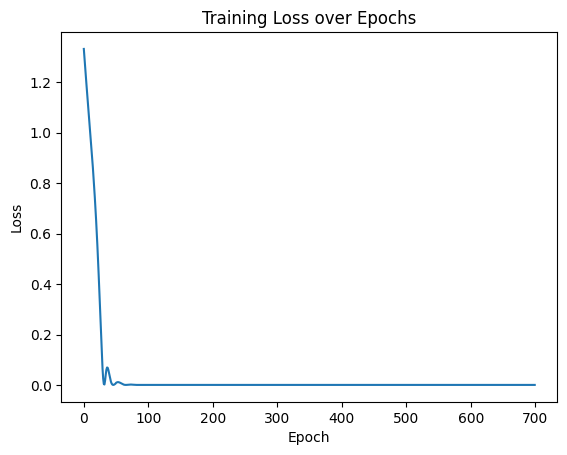

 70%|███████   | 700/1000 [23:16<10:35,  2.12s/it]

tensor([[[0.1278]]], device='cuda:0')
tensor([[0.1279]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322653, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 75%|███████▍  | 749/1000 [24:55<08:16,  1.98s/it]

Epoch [750/1000], Loss: 0.0003


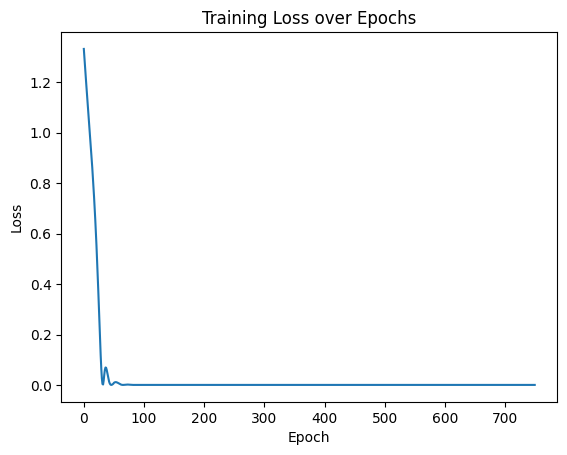

 75%|███████▌  | 750/1000 [24:57<08:29,  2.04s/it]

tensor([[[0.1279]]], device='cuda:0')
tensor([[0.1279]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322654, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|███████▉  | 799/1000 [26:34<06:49,  2.04s/it]

Epoch [800/1000], Loss: 0.0003


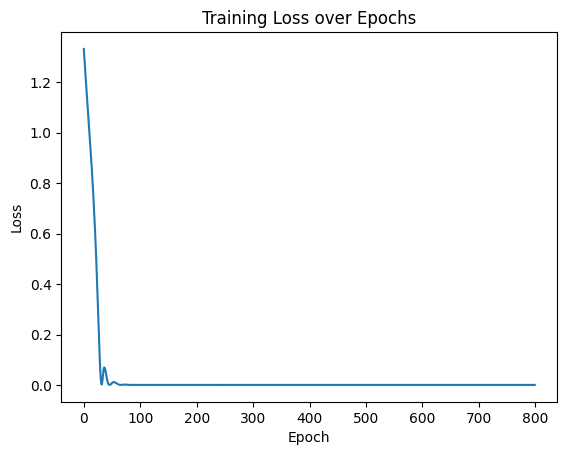

 80%|████████  | 800/1000 [26:36<06:57,  2.09s/it]

tensor([[[0.1279]]], device='cuda:0')
tensor([[0.1280]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322655, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 85%|████████▍ | 849/1000 [28:17<05:28,  2.18s/it]

Epoch [850/1000], Loss: 0.0003


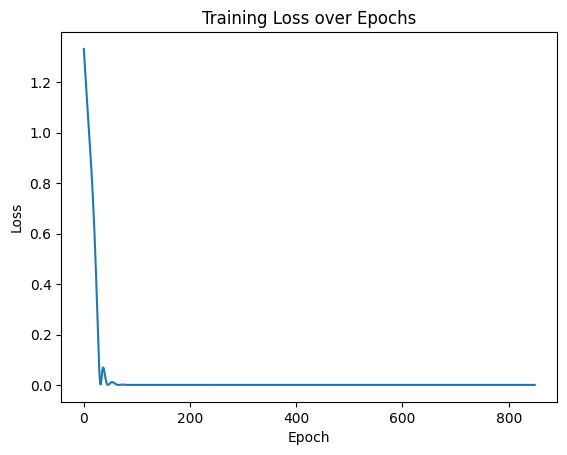

 85%|████████▌ | 850/1000 [28:20<05:33,  2.22s/it]

tensor([[[0.1280]]], device='cuda:0')
tensor([[0.1280]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322656, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 90%|████████▉ | 899/1000 [29:56<03:10,  1.89s/it]

Epoch [900/1000], Loss: 0.0003


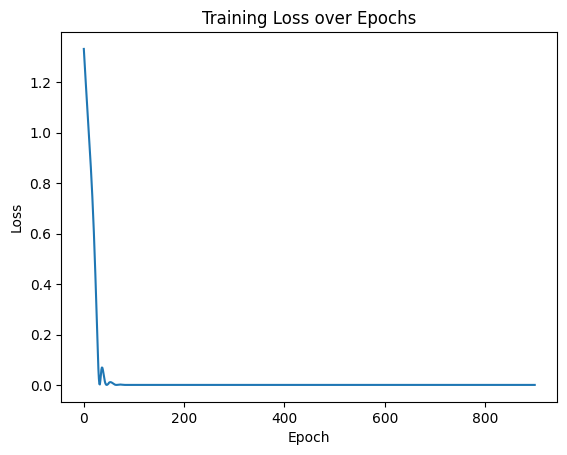

 90%|█████████ | 900/1000 [29:58<03:12,  1.93s/it]

tensor([[[0.1280]]], device='cuda:0')
tensor([[0.1281]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322657, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 95%|█████████▍| 949/1000 [31:35<01:40,  1.97s/it]

Epoch [950/1000], Loss: 0.0003


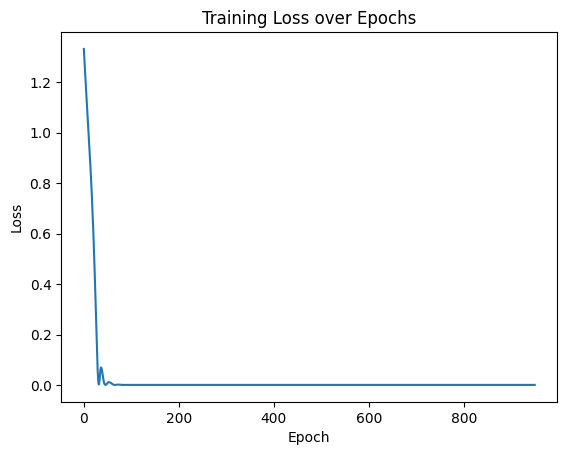

 95%|█████████▌| 950/1000 [31:37<01:42,  2.04s/it]

tensor([[[0.1281]]], device='cuda:0')
tensor([[0.1281]], device='cuda:0')


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322658, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 999/1000 [33:18<00:01,  2.00s/it]

Epoch [1000/1000], Loss: 0.0003


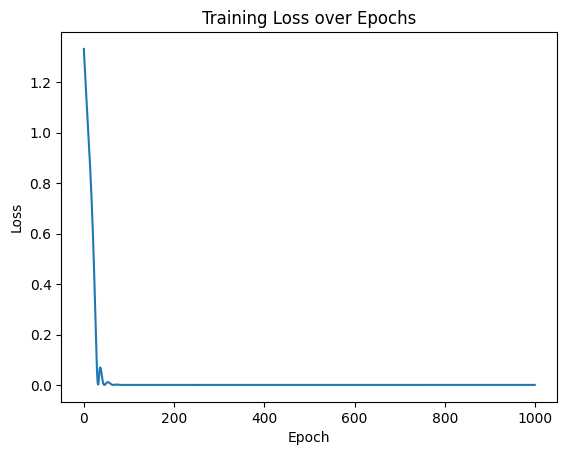

100%|██████████| 1000/1000 [33:20<00:00,  2.00s/it]

tensor([[[0.1281]]], device='cuda:0')
tensor([[0.1281]], device='cuda:0')


In [28]:
# Parameters
input_size = 1  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
forecast_interval = 50
losses = []
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    # Probabilistic forecasting every forecast_interval timestamps
    if (epoch+1) % forecast_interval == 0:
        with torch.no_grad():
            # Generate probabilistic forecasts for the next timestamp
            # You can adjust this part to implement your desired forecasting method
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # # Visualize the loss over epochs
            # plt.plot(losses)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.title('Training Loss over Epochs')
            # plt.show()

            forecast_input = data_tensor[:, -1:, :]  # Use the last timestamp as input
            forecast_output = model(forecast_input)
            print(forecast_input)
            print(forecast_output)
            
            # Append the forecasted values to the data tensor
            data_tensor = torch.cat([data_tensor, forecast_output.unsqueeze(1)], dim=1)

### Save Modal for more evaulation

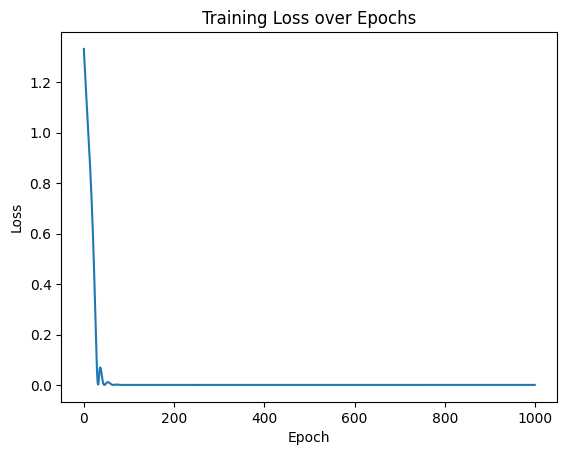

In [30]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [31]:
# Save the trained model to local device
torch.save(model.state_dict(), './TrainedModals/lstm_model_2023.pth')

### Evaulate saved modal

In [32]:
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)